# Exploring different Neural Architecture Search frameworks


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from model_utils.augment import num_to_bin, bin_to_num


In [3]:
sns.set_theme(style="dark", font_scale=1.1)

DATASETS = os.path.join('..', '..', 'Datasets', 'numpy_datasets')
MODEL_PATH = os.path.join('..', 'models')
OPT_LOGS = os.path.join('..', 'opt_logs')


In [4]:
angelina = os.path.join(DATASETS, "angelina.npz")
# dsbi = os.path.join(DATASETS, "dsbi.npz")

data = np.load(angelina)
# ood = np.load(dsbi)
print(data['train_x'].shape)
# print(ood['test_x'].shape)

(65429, 40, 30, 3)


In [5]:

train_X = data["train_x"]
train_Y = data["train_y"]

N_base, p = train_Y.shape
N = int(0.1 * N_base)
np.random.seed(110011)
subset = np.random.choice(np.arange(0, N_base), N)

train_X = train_X[subset]
train_Y = train_Y[subset]


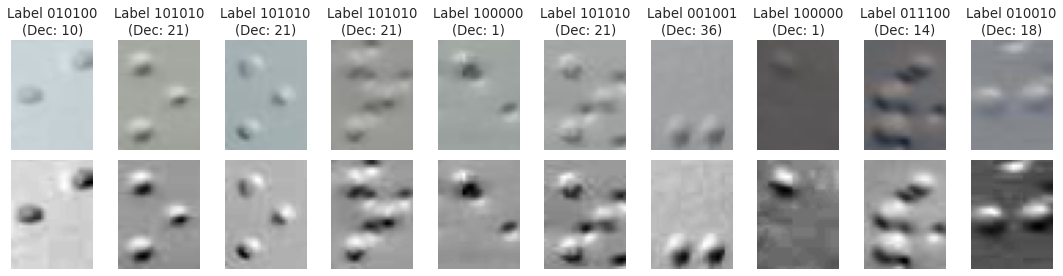

In [6]:
plt.figure(figsize=(15,4))
np.random.seed(101010)
subset = np.random.choice(np.arange(0, N), 10)

for i in range(10):
    sample = train_X[subset[i]]
    plt.subplot(2,10, i+1)
    plt.axis("off")
    lbl = ''.join(train_Y[subset[i]].astype(str))
    num_lbl = bin_to_num(lbl)
    plt.imshow(sample)
    plt.title("Label {}\n(Dec: {})".format(lbl, num_lbl))
    
    gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
    plt.subplot(2,10, i+11)
    plt.axis("off")
    plt.gray()
    plt.imshow(gray)
    
    # norm = cv2.normalize(cv2.convertScaleAbs(gray, alpha=1.3, beta=0), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # # norm = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
    # plt.subplot(3,10, i+21)
    # plt.axis("off")
    # plt.imshow(norm)
    # print(f"Min / Max before norm: {np.min(gray)} / {np.max(gray)} and after: {round(np.min(norm), 2)}  / {round(np.max(norm), 2)}")
plt.tight_layout()

## Model definition

In [7]:
from sklearn.model_selection import KFold

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from bayes_optim import BO, ParallelBO, RealSpace, IntegerSpace, DiscreteSpace
from bayes_optim.surrogate import RandomForest as BO_RF
import time
from datetime import datetime
from tqdm import tqdm

from model_utils.metrics import bitwise_accuracy


In [8]:
def myDataLoader(data_x, data_y, batch_sz):
    tensor_x = torch.Tensor(data_x)
    tensor_y = torch.Tensor(data_y)

    return DataLoader(TensorDataset(tensor_x,tensor_y), batch_size=batch_sz)

In [23]:
train_X.shape[1:]

(40, 30, 3)

In [24]:
DEV = 'cuda'
torch.set_default_device(DEV)

class ConvModel(nn.Module):
    def __init__(self, in_size=(40,30,3), filts=32, kerns=3, pad=1,
                activ=F.relu, dense_sz=100):
        super().__init__()
        H, W, C = in_size
        self.activ = activ
        # Conv out = input_dim - kern + 2 * pad + 1
        
        self.conv1 = nn.Conv2d(in_channels=C, out_channels=filts, kernel_size=kerns, padding=pad)
        out1 = (H - kerns + 2 * pad + 1, W - kerns + 2 * pad + 1, filts)
        self.conv2 = nn.Conv2d(in_channels=filts, out_channels=filts, kernel_size=kerns, padding=pad)
        out2 = (out1[0] - kerns + 2 * pad + 1, out1[1] - kerns + 2 * pad + 1, filts)
        self.pool = nn.MaxPool2d(2, 2)
        out_p = (out2[0] // 2, out2[1] // 2, filts)
        self.conv3 = nn.Conv2d(in_channels=filts, out_channels=2*filts, kernel_size=kerns, padding=pad)
        out3 = (out_p[0] - kerns + 2 * pad + 1, out_p[1] - kerns + 2 * pad + 1, 2 * filts)
        self.conv4 = nn.Conv2d(in_channels=2*filts, out_channels=2*filts, kernel_size=kerns, padding=pad)
        out4 = (out3[0] - kerns + 2 * pad + 1, out3[1] - kerns + 2 * pad + 1, 2 * filts)
        out_p2 = (out4[0] // 2, out4[1] // 2, 2 * filts)
        self.fc1 = nn.Linear(np.product(out_p2), dense_sz)
        self.fc2 = nn.Linear(dense_sz, 6)

        
    def forward(self, x):
        # From: [batch_size, height, width, channels]
        # To: [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2)
        
        x = self.activ(self.conv1(x))
        x = self.pool(self.activ(self.conv2(x)))
        x = self.activ(self.conv2(x))
        x = self.pool(self.activ(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.activ(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

    
class HyperModel:
    def __init__(self, in_size=(40,30,3), filts=32, kerns=3, pad=1, # same = 1, valid = 0
                activ=F.relu, dense_sz=100, beta_1=0.9, beta_2=0.999, lr=0.001, l2=0.002):
        self.model = ConvModel(in_size=in_size, filts=filts, kerns=kerns, pad=pad,
                               activ=activ, dense_sz=dense_sz)
        self.criterion = nn.BCELoss()
        self.optimiser = optim.Adam(self.model.parameters(), lr=lr, betas=(beta_1, beta_2), weight_decay=l2)
        
        self.trained_epochs = 0
        self.conv_epoch = 0
        self.min_weights = self.model.state_dict()
        self.history = {}
        self.l2 = l2
        

    def train(self, train_loader, val_loader, epochs=10, patience=3, verbose=2):
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        min_v_loss = np.inf
        stagnant_count = 0
        
        prev_l, prev_a, prev_vl, prev_va = 0., 0., 0., 0.
        for epoch in (pbar := tqdm(range(epochs), total=epochs, disable=verbose!=0)):
            pbar.set_description(f"Training model - l {round(prev_l,4)}, vl {round(prev_vl,4)}; a {round(prev_a,4)}, va {round(prev_va,4)}")
            train_loss = 0.0
            train_acc = 0.0
            for i, (inputs, labels) in tqdm(enumerate(train_loader), disable=(verbose < 2),
                                desc=f"Epoch {epoch}", total=len(train_loader)):
                inputs, labels = inputs.to(DEV), labels.to(DEV)
                
                self.optimiser.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimiser.step()

                train_loss += loss.item()
                train_acc += bitwise_accuracy((outputs > 0.5).int(), labels)
                
            val_loss = 0.0
            val_acc = 0.0
            self.model.eval()
            with torch.no_grad():
                for j, (vinputs, vlabels) in tqdm(enumerate(val_loader), disable=(verbose < 2),
                                desc=f"Evaluating valdiation set", total=len(val_loader)):
                    vinputs, vlabels = vinputs.to(DEV), vlabels.to(DEV)
                    
                    voutputs = self.model(vinputs)
                    vloss = self.criterion(voutputs, vlabels)
                    
                    val_loss += vloss.item()
                    val_acc += bitwise_accuracy((voutputs > 0.5).int(), vlabels)
            self.model.train()
            # avg_vloss = running_vloss / len(validation_loader)
            
            train_loss /= len(train_loader)
            train_acc /= len(train_loader)
            val_loss /= len(val_loader)
            val_acc /= len(val_loader)
            
            if epoch > 1:
                if prev_vl - val_loss > 0:
                    stagnant_count = 0
                    if val_loss < min_v_loss:
                        min_v_loss = val_loss
                        self.min_weights = self.model.state_dict()
                        self.conv_epoch = epoch
                        # if write_dir:
                        #     torch.save(self.model.state_dict(), model_path.format(timestamp, epoch_number))
                else:
                    stagnant_count += 1
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
            prev_l, prev_a, prev_vl, prev_va = train_loss, train_acc, val_loss, val_acc
            # print(prev_l, prev_a, prev_vl, prev_va)
            
            if verbose > 0:
                print(f'E{epoch}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f} -- train acc: {train_acc:.4f}, val acc: {val_acc:.4f}')
            if stagnant_count > patience:
                break
        
        self.model.load_state_dict(self.min_weights)
        self.history['train_loss'] = train_losses
        self.history['val_loss'] = val_losses
        self.history['train_acc'] = train_accs
        self.history['val_acc'] = val_accs
        self.trained_epochs = epoch+1
        return self.history
    
    
    def reevaluate(self, data_loader):
        loss = 0.0
        acc = 0.0
        self.model.eval()
        with torch.no_grad():
            for j, data in enumerate(data_loader):
                inputs, labels = data
                outputs = self.model(inputs)
                batch_loss = self.criterion(outputs, labels)
                loss += batch_loss.item() / len(data_loader)
                
                outputs = (outputs > 0.5).int()
                batch_acc = bitwise_accuracy(outputs, labels)
                acc += batch_acc / len(data_loader)
        return loss, acc
            
    def save(self, path):
        torch.save(self.state_dict(), path)


In [25]:
# model = HyperModel()
# train_loader = myDataLoader(train_X, train_Y, batch_sz=16)
# val_loader = myDataLoader(train_X, train_Y, batch_sz=16)

# model.train(train_loader, val_loader, epochs=10, patience=2)
# model.reevaluate(train_loader)

In [148]:
activations = {
    0: F.relu,
    1: F.tanh
}

def train_model(model_args, #lr, beta_1, beta_2, filters, kernel_sz, dense_sz, activs, padding,
                x_data=train_X, y_data=train_Y, batch_sz=1024, epochs=10, pat=3, verbose=-1, return_all=False):
    # lr, beta_1, beta_2, filters, kernel_sz, dense_sz, activs, padding = model_args
    lr, beta_1, beta_2, l2, filters, kernel_sz, dense_sz, activs, padding = model_args
    print(f"lr {round(lr, 4)}, beta_1 {round(beta_1, 4)}, beta_2 {round(beta_2, 4)}, l2 {round(l2, 4)}, filters {filters}, kernel_sz {kernel_sz}, ",
          f"dense_sz {dense_sz}, activs {activations[activs].__name__}, padding {padding}")
    
    kfold = KFold(10, shuffle=True, random_state=1)
    
    accs, losses, ratios = [], [], []
    start_t = time.time()
    for  f, (train_ix, val_ix) in enumerate(kfold.split(x_data)):
        f_t = time.time()
        model = HyperModel(in_size=x_data.shape[1:], filts=filters, kerns=kernel_sz, pad=padding,
                            activ=activations[activs], dense_sz=dense_sz, beta_1=beta_1, beta_2=beta_2, lr=lr, l2=l2)
        
        trainX, trainY, valX, valY = x_data[train_ix], y_data[train_ix], x_data[val_ix], y_data[val_ix]
        train_loader = myDataLoader(trainX, trainY, batch_sz=batch_sz)
        val_loader = myDataLoader(valX, valY, batch_sz=batch_sz)
                
        history = model.train(train_loader, val_loader, epochs=epochs, patience=pat, verbose=verbose)
        # t_loss, t_acc = model.reevaluate(train_loader)
        # loss, acc = model.reevaluate(val_loader)
        ce = model.conv_epoch
        t_loss, t_acc = history['train_loss'][ce], history['train_acc'][ce]
        loss, acc = history['val_loss'][ce], history['val_acc'][ce]
        
        print(f"Fold {f} trained {model.trained_epochs} epochs in {round(time.time() - f_t, 3)}s. ",
              f"Loss: tr - {round(t_loss, 3)}, val - {round(loss, 3)}. ",
              f"Accuracy: tr - {round(t_acc, 3)}, val - {round(acc, 3)}.")
        
        accs.append(acc)
        losses.append(loss)
        ratios.append(t_loss / loss)
    print(f"Cross-validation completed in {round(time.time() - start_t, 3)}s. Mean validation loss {round(np.mean(losses), 3)} and acc {round(np.mean(accs), 3)}")
    print('-'*75)
    if return_all:
        return losses, accs, ratios
    else:
        return np.mean(losses)

## Bayesian Optimisation

In [130]:
BAYES_LOGS = os.path.join(OPT_LOGS, 'bayes_opt')
if not os.path.exists(BAYES_LOGS):
    os.makedirs(BAYES_LOGS)

In [131]:

now = datetime.now().strftime( "%Y%m%d-%H%M%S")

space = (
    RealSpace([0.0001, 0.01], var_name='lr')
    + RealSpace([0.85, 0.95], var_name='beta_1')
    + RealSpace([0.99, 0.9999], var_name='beta_2')
    + RealSpace([0.0005, 0.02], var_name='l2')
    + IntegerSpace([16, 64], var_name='filters')
    + IntegerSpace([2, 5], var_name='kernel_sz')
    + IntegerSpace([25, 150], var_name='dense_sz')
    + IntegerSpace([0, 1], var_name='activs')
    + IntegerSpace([0, 1], var_name='padding')
    # + RealSpace([0.0005, 0.002], var_name='dense_l2')
)

bo_model = BO_RF(n_estimators=25, levels={})

MAX_CONF = 100
optimizer = BO(
    search_space=space,
    obj_fun=train_model,
    verbose=True,
    DoE_size=5,
    max_FEs=MAX_CONF,
    random_seed=1,
    model=bo_model,
    data_file=os.path.join(BAYES_LOGS, f'BO_{now}')
)

start = time.time()
optimizer.run()
end = time.time()

print('Bayes optimization takes {:.2f} seconds to tune {} configurations'.format(end - start, MAX_CONF))
print(optimizer)

05/15/2024 07:30:26,918 - [BO (140569664263600).INFO] -- iteration 0 starts...
05/15/2024 07:30:26,922 - [BO (140569664263600).INFO] -- asking 5 points (using DoE):
05/15/2024 07:30:26,922 - [BO (140569664263600).INFO] -- #1 - [0.0015980446892244953, 0.8748010369762073, 0.9937457121504588, 0.014932905112709364, 43, 3, 43, 0, 0]
05/15/2024 07:30:26,922 - [BO (140569664263600).INFO] -- #2 - [0.006693050756686904, 0.8527526656418187, 0.9944438564253367, 0.005823304065378988, 30, 5, 104, 1, 0]
05/15/2024 07:30:26,922 - [BO (140569664263600).INFO] -- #3 - [0.0035950632006830213, 0.9287188703972543, 0.990451370583813, 0.0020792759138041177, 36, 4, 106, 0, 1]
05/15/2024 07:30:26,923 - [BO (140569664263600).INFO] -- #4 - [0.009132595883531179, 0.9380800407589336, 0.9969872559320065, 0.00999763758891005, 50, 2, 53, 1, 1]
05/15/2024 07:30:26,923 - [BO (140569664263600).INFO] -- #5 - [0.005390295993236286, 0.9083616445573646, 0.9984248224366956, 0.019590257752595815, 26, 2, 147, 1, 0]
05/15/2024 

In [146]:
optimizer.xopt.to_dict()

{'lr': 0.0008378693402342123,
 'beta_1': 0.8978616699507355,
 'beta_2': 0.9947658989213924,
 'l2': 0.019890688370674918,
 'filters': 58,
 'kernel_sz': 3,
 'dense_sz': 141,
 'activs': 0,
 'padding': 1}

In [147]:
# lr, beta_1, beta_2, filters, kernel_sz, dense_sz, activs, padding, l2
bayes_opt_params = optimizer.xopt.to_dict().values()
bayes_opt_params

dict_values([0.0008378693402342123, 0.8978616699507355, 0.9947658989213924, 0.019890688370674918, 58, 3, 141, 0, 1])

## F-Race

In [32]:
FRACE_LOGS = os.path.join(OPT_LOGS, 'f_race')
if not os.path.exists(FRACE_LOGS):
    os.makedirs(FRACE_LOGS)

### Notes

- Select number of candidates to test (Sobol sequence? Skip first 32 sequences if 20 candidates selected)
- Execute one step of evaluation on each candidate, and rank results
- Apply Friedman test for rank-variance to determine significant difference in groups
    - If appropriate, apply Wilcoxon signed rank test post-hoc to test candidate pairs (Bonferoni correction, Holm step-down, None?)
    - Discard significantly weaker candidates (All candidate configurations that result significantly worse than the best one are discarded, where best is determined by lowest expected rank)
- After all steps / computational budget - number of iterations `L = 2 + round(log2(d)) = 5`, filter remaining candidate set down to min number, if exceeding
    - Suggested minimum: `2 + round(log2(d)) = 5`
- Rank remaining candidates, assign weight proportional to rank
- Sample next set of candidates around elite, with distribution for each param space:
    - Config around `Xz = (xz1, xz2, ..., xzm)` with `m` the number of parameters, where `Xz` is one elite candidate
    - Normal distribution around mean `xzi`
    - Std Dev is `vi . (1 / (N+1))^(l/d)` with `vi` = range of param `i`, `l` is the iteration counter, `N` is number of candidates to sample, and `d` is number of components of a configuration (`=m`)
- 

In [33]:
from scipy.stats import friedmanchisquare, wilcoxon
from scipy.stats.qmc import Sobol

In [209]:
activations = {
    0: F.relu,
    1: F.tanh
}
N_MIN = 5
ALPHA = 0.05

def train_one_fold(model_args, train_loader, val_loader, epochs=10, pat=3, verbose=-1):
    lr, beta_1, beta_2, l2, filters, kernel_sz, dense_sz, activs, padding, sz = model_args
    print(f"lr {round(lr, 4)}, beta_1 {round(beta_1, 4)}, beta_2 {round(beta_2, 4)}, l2 {round(l2, 4)}, filters {filters}, kernel_sz {kernel_sz}, ",
          f"dense_sz {dense_sz}, activs {activations[activs].__name__}, padding {padding}")
      
    model = HyperModel(in_size=sz, filts=filters, kerns=kernel_sz, pad=padding,
                        activ=activations[activs], dense_sz=dense_sz, beta_1=beta_1, beta_2=beta_2, lr=lr, l2=l2)
    history = model.train(train_loader, val_loader, epochs=epochs, patience=pat, verbose=verbose)
    
    ce = model.conv_epoch
    t_loss, t_acc = history['train_loss'][ce], history['train_acc'][ce]
    loss, acc = history['val_loss'][ce], history['val_acc'][ce]
    
    return model.trained_epochs, t_loss, loss, t_acc, acc

def train_models_frace(model_configs: dict, loss_history: dict, acc_history: dict, #lr, beta_1, beta_2, filters, kernel_sz, dense_sz, activs, padding,
                x_data=train_X, y_data=train_Y, batch_sz=1024, epochs=10, pat=3, verbose=-1):
    # lr, beta_1, beta_2, filters, kernel_sz, dense_sz, activs, padding = model_args
    
    kfold = KFold(10, shuffle=True, random_state=1)
    
    accs, losses = {}, {}
    for key in model_configs:
        accs[key] = acc_history[key] if key in acc_history else []
        losses[key] = loss_history[key] if key in loss_history else []
    
    start_t = time.time()
    for  f, (train_ix, val_ix) in enumerate(kfold.split(x_data)):
        trainX, trainY, valX, valY = x_data[train_ix], y_data[train_ix], x_data[val_ix], y_data[val_ix]
        train_loader = myDataLoader(trainX, trainY, batch_sz=batch_sz)
        val_loader = myDataLoader(valX, valY, batch_sz=batch_sz)
        print(f"Training fold {f} on list of {len(model_configs)} configurations.")
              
        for (config_idx, model_args) in model_configs.items():
            if len(losses[config_idx]) > f:
                print(f"Configuration {config_idx}, evaluated once before -- skipping.")
                continue
            f_t = time.time()        
            # model_args.append(x_data.shape[1:])
            trained, t_loss, loss, t_acc, acc = train_one_fold(model_args + [x_data.shape[1:]], train_loader, val_loader,
                                                               epochs=epochs, pat=pat, verbose=verbose)
            
            print(f"Configuration {config_idx}, fold {f} trained {trained} epochs in {round(time.time() - f_t, 3)}s. ",
                    f"Loss: tr - {round(t_loss, 3)}, val - {round(loss, 3)}. ",
                    f"Accuracy: tr - {round(t_acc, 3)}, val - {round(acc, 3)}.")
            accs[config_idx].append(acc)
            losses[config_idx].append(loss)
            
        # perform Friedman tests on losses to determine if configs are dropped
        df = pd.DataFrame({key: pd.Series(value) for key, value in losses.items()}).dropna()
        F, pval_friedman = friedmanchisquare(*df.to_numpy().T)
        if pval_friedman < ALPHA:
            print(f"Significant difference in validation losses across group, after {f+1} folds ({pval_friedman})")
            # TODO: perform Wilcoxon test pairing highest rank configuration with the rest
            means = df.apply('mean', axis=0).sort_values()
            ranks = means.index
            best_config = df[ranks[0]]
            other_configs = df[ranks[1:]]
        
            alpha_adj = 1-pow(1-ALPHA, 1. / other_configs.shape[1]) # Sidak correction
            for conf in other_configs:
                W, pval_wilcoxon = wilcoxon(best_config, other_configs[conf], alternative='less')
                # if alpha_adj < pval_wilcoxon < ALPHA:
                #     print(f"Configuration {conf} (mean vloss {means[conf]}) pvalue {pval_wilcoxon} against configuration {ranks[0]} (mean vloss {means[ranks[0]]}) -- inbetween alpha and adjusted alpha.")
                # if pval_wilcoxon < alpha_adj:
                if pval_wilcoxon < ALPHA:
                    # Drop configuration from further testing
                    print(f"Configuration {conf} (mean vloss {means[conf]}) dropped with pvalue {pval_wilcoxon} against configuration {ranks[0]} (mean vloss {means[ranks[0]]})")
                    model_configs.pop(conf)
                    losses.pop(conf)
                    accs.pop(conf)
            print("Paired tests completed")
        else:
            print(f"Not enough evidence to support a difference across group, after {f+1} folds ({pval_friedman})")

        if len(model_configs) <= N_MIN:
            break
        print('-'*100)
        
    print(f"Iteration completed in {round(time.time() - start_t, 3)}s. Remaining configurations {len(model_configs)}. ",
          f"Mean validation loss {np.round(np.mean(list(losses.values()), axis=None), 3)} and acc {np.round(np.mean(list(accs.values()), axis=None), 3)}")
    print('-'*75)
    return model_configs, losses, accs

In [208]:
np.mean(list(loss_history.values()), axis=None)

0.04867147199809551

In [161]:
ranks_records = []
scores_records = []
configs_records = []

In [169]:
space_f = {
    'lr': (0.0001, 0.01),
    'beta_1': (0.85, 0.95),
    'beta_2': (0.99, 0.9999),
    'l2': (0.0005, 0.02),
    'filters': (16, 64),
    'kernel_sz': (2,5),
    'dense_sz': (25, 150),
    'activs': (0, 1),
    'padding': (0, 1)
}
INT_IDX = 4
BIN_IDX = 7

space_ranges = {
    'lr': space_f['lr'][1] - space_f['lr'][0],
    'beta_1': space_f['beta_1'][1] - space_f['beta_1'][0],
    'beta_2': space_f['beta_2'][1] - space_f['beta_2'][0],
    'l2': space_f['l2'][1] - space_f['l2'][0],
    'filters': space_f['filters'][1] - space_f['filters'][0] + 1,
    'kernel_sz': space_f['kernel_sz'][1] - space_f['kernel_sz'][0] + 1,
    'dense_sz': space_f['dense_sz'][1] - space_f['dense_sz'][0] + 1,
    'activs': space_f['activs'][1] - space_f['activs'][0] + 1,
    'padding': space_f['padding'][1] - space_f['padding'][0] + 1
}

discrete_dists = {
    # 'filters': np.repeat(1 / space_ranges['filters'], space_ranges['filters']),
    # 'kernel_sz': np.repeat(1 / space_ranges['kernel_sz'], space_ranges['kernel_sz']),
    # 'dense_sz': np.repeat(1 / space_ranges['dense_sz'], space_ranges['dense_sz']),
    'activs': np.repeat(1 / space_ranges['activs'], space_ranges['activs']),
    'padding': np.repeat(1 / space_ranges['padding'], space_ranges['padding'])
}

N = 30
D = len(space_f)
# sample N configurations
model_configs = {}
loss_history = {}
acc_history = {}

SAMPLER = Sobol(d=D)
_ = SAMPLER.fast_forward(32)

points = SAMPLER.random_base2(m=5)
for i in range(N):
    sample = points[i]
    params = [p * (ub - lb) + lb for p, (lb, ub) in zip(sample, space_f.values())]
    params = [p if idx < INT_IDX else round(p) for idx, p in enumerate(params)]
    model_configs[i] = params
IDX = N

L = 6

start = time.time()
for l in range(1, L+1):
    print("#" * 100)
    print(f"Iteration {l} of Iterated F-race.")
    model_configs, loss_history, acc_history = train_models_frace(model_configs, loss_history, acc_history,
                                                                  x_data=train_X, y_data=train_Y, batch_sz=1024,
                                                                  epochs=10, pat=3, verbose=-1)
    
    N_e = len(model_configs)

    scores = {idx: np.mean(loss_history[idx]) for idx in model_configs}
    ranks = list(dict(sorted(scores.items(), key=lambda x: x[1])).keys())
    if N_e > N_MIN:
        print(f"More than desired minimum configurations remaining: {N_e}")
        for i in range(N_MIN, N_e):
            idx = ranks[i]
            model_configs.pop(idx)
            loss_history.pop(idx)
            acc_history.pop(idx)
            scores.pop(idx)
        ranks = ranks[:N_MIN]
    if l == L:
        break
        
    # Select elite to sample (new one for every new sample? Or once for all new samples?)
    weights = {idx: (N_e - ranks.index(idx)) / (N_e * (N_e + 1) / 2) for idx in model_configs}
    cum_weights = np.cumsum(list(weights.values()))
    r = np.random.rand()
    
    sample_idx = list(weights.keys())[np.searchsorted(cum_weights, r)]
    sample_config = model_configs[sample_idx]
    
    # Keep only sampled elite config, and global best config
    for key in [k for k in model_configs if k != sample_idx and k != ranks[0]]:
        model_configs.pop(key)
        loss_history.pop(key)
        acc_history.pop(key)
    
    # Recompute sampling parameters
    N_e = len(model_configs)
    sig_mult = pow(1 / N, l / D)
    
    for pi, (key, param) in enumerate(zip(space_f, sample_config)):
        if pi < BIN_IDX:
            continue
        discrete_dists[key] = np.array([pr * (1 - l / L) + int(idx + space_f[key][0] == param) * l / L
                                        for idx, pr in enumerate(discrete_dists[key])])
    
    for i in range(N_e, N):
        # Sample around parameters of elite candidate
        new_conf = []
        for pi, (key, param) in enumerate(zip(space_f, sample_config)):
            bounds = space_f[key]
            if pi < BIN_IDX:             
                sample = np.random.normal(param, space_ranges[key] * sig_mult)
                sample = bounds[0] if sample < bounds[0] else bounds[1] if sample > bounds[1] else sample
                if pi >= INT_IDX:
                    sample = round(sample)
            else:
                cum_weights = np.cumsum(discrete_dists[key])
                r = np.random.rand()

                sample_idx = np.searchsorted(cum_weights, r)
                sample = list(range(bounds[0], bounds[1]+1))[sample_idx]
            new_conf.append(sample)

        # Assign IDX to new candidate, and increment IDX
        model_configs[IDX] = new_conf
        IDX += 1

end = time.time()

ranks_records.append(ranks)
scores_records.append(scores)
configs_records.append(model_configs)
print('Iterated F-race takes {:.2f} seconds to tune roughly {} configurations'.format(end - start, N * L))

####################################################################################################
Iteration 1 of Iterated F-race.
Training fold 0 on list of 30 configurations.
lr 0.0078, beta_1 0.9415, beta_2 0.9903, l2 0.0179, filters 50, kernel_sz 3,  dense_sz 59, activs tanh, padding 0
Configuration 0, fold 0 trained 10 epochs in 5.048s.  Loss: tr - 0.659, val - 0.655.  Accuracy: tr - 0.589, val - 0.596.
lr 0.0042, beta_1 0.8754, beta_2 0.9993, l2 0.0024, filters 38, kernel_sz 5,  dense_sz 88, activs relu, padding 1
Configuration 1, fold 0 trained 10 epochs in 4.356s.  Loss: tr - 0.648, val - 0.639.  Accuracy: tr - 0.616, val - 0.68.
lr 0.0022, beta_1 0.9068, beta_2 0.9946, l2 0.0109, filters 24, kernel_sz 4,  dense_sz 54, activs relu, padding 1
Configuration 2, fold 0 trained 10 epochs in 2.727s.  Loss: tr - 0.459, val - 0.41.  Accuracy: tr - 0.787, val - 0.777.
lr 0.006, beta_1 0.8728, beta_2 0.995, l2 0.0093, filters 60, kernel_sz 3,  dense_sz 147, activs tanh, padding 0
Confi

In [176]:
ranks[:N_MIN]

[78, 164, 171, 167, 153]

In [177]:
np.set_printoptions(suppress=True) 

# lr, beta_1, beta_2, l2, filters, kernel_sz, dense_sz, activs, padding
print(np.round(model_configs[78], 10))
print(np.round(loss_history[78], 10))
print(f"Mean {np.mean(loss_history[78])}")

[  0.00083729   0.86430548   0.9999       0.01922641  54.
   4.         150.           0.           1.        ]
[0.02425255 0.02148129 0.05057108 0.0266208  0.03987708 0.0379369
 0.03530578 0.05130914 0.02703423 0.02511398]
Mean 0.03395028319209814


In [178]:
print(np.round(model_configs[164], 10))
print(np.round(loss_history[164], 10))
print(f"Mean {np.mean(loss_history[164])}")

[ 0.00050726  0.87423688  0.99807679  0.01167818 43.          4.
 73.          0.          1.        ]
[0.02864042 0.03718297 0.03719274 0.02931892 0.04071383 0.09852061
 0.09436682 0.05758991 0.03873058 0.02171141]
Mean 0.04839682150632143


In [179]:
print(np.round(model_configs[171], 10))
print(np.round(loss_history[171], 10))
print(f"Mean {np.mean(loss_history[171])}")

[ 0.00050747  0.89036671  0.99870419  0.01465391 30.          5.
 50.          0.          1.        ]
[0.03659145 0.03401849 0.05330357 0.04757323 0.03280251 0.05103321
 0.08445738 0.06837597 0.03831699 0.08287126]
Mean 0.05293440669775009


## Evaluate / Compare

In [151]:
def summarize_performance(scores, measure = "Accuracy"):
    plt.figure(figsize=(10,5))
    plt.title('%s: mean=%.3f std=%.3f, n=%d' % (measure, np.mean(scores.values), np.std(scores.values), len(scores)))
    sns.set_style("darkgrid")
    sns.violinplot(data=scores, cut=0)
    # plt.gca().get_xaxis().set_visible(False)

In [154]:
bayes_losses, bayes_accs, bayes_ratios = train_model(list(bayes_opt_params), return_all=True)

lr 0.0008, beta_1 0.8979, beta_2 0.9948, l2 0.0199, filters 58, kernel_sz 3,  dense_sz 141, activs relu, padding 1
Fold 0 trained 10 epochs in 7.111s.  Loss: tr - 0.026, val - 0.021.  Accuracy: tr - 0.992, val - 0.991.
Fold 1 trained 10 epochs in 6.774s.  Loss: tr - 0.049, val - 0.042.  Accuracy: tr - 0.984, val - 0.988.
Fold 2 trained 10 epochs in 6.826s.  Loss: tr - 0.047, val - 0.046.  Accuracy: tr - 0.985, val - 0.988.
Fold 3 trained 10 epochs in 6.78s.  Loss: tr - 0.031, val - 0.031.  Accuracy: tr - 0.991, val - 0.988.
Fold 4 trained 10 epochs in 6.796s.  Loss: tr - 0.043, val - 0.036.  Accuracy: tr - 0.986, val - 0.988.
Fold 5 trained 10 epochs in 6.795s.  Loss: tr - 0.025, val - 0.029.  Accuracy: tr - 0.993, val - 0.992.
Fold 6 trained 10 epochs in 6.82s.  Loss: tr - 0.101, val - 0.079.  Accuracy: tr - 0.967, val - 0.974.
Fold 7 trained 10 epochs in 7.125s.  Loss: tr - 0.031, val - 0.031.  Accuracy: tr - 0.99, val - 0.99.
Fold 8 trained 10 epochs in 6.814s.  Loss: tr - 0.136, va

In [180]:
overall_accs = pd.DataFrame({'Bayes': bayes_accs})
overall_losses = pd.DataFrame({'Bayes': bayes_losses})
overall_ratios = pd.DataFrame({'Bayes': bayes_ratios})

In [188]:
for i in ranks:
    args = model_configs[i]
    losses, accs, ratios = train_model(args, return_all=True)
    overall_losses[f"F-race {i}"] = losses
    overall_accs[f"F-race {i}"] = accs
    overall_ratios[f"F-race {i}"] = ratios

lr 0.0008, beta_1 0.8643, beta_2 0.9999, l2 0.0192, filters 54, kernel_sz 4,  dense_sz 150, activs relu, padding 1
Fold 0 trained 10 epochs in 8.025s.  Loss: tr - 0.082, val - 0.061.  Accuracy: tr - 0.973, val - 0.983.
Fold 1 trained 10 epochs in 8.087s.  Loss: tr - 0.037, val - 0.031.  Accuracy: tr - 0.989, val - 0.992.
Fold 2 trained 10 epochs in 8.012s.  Loss: tr - 0.053, val - 0.05.  Accuracy: tr - 0.982, val - 0.986.
Fold 3 trained 10 epochs in 8.041s.  Loss: tr - 0.052, val - 0.048.  Accuracy: tr - 0.982, val - 0.985.
Fold 4 trained 10 epochs in 8.316s.  Loss: tr - 0.035, val - 0.028.  Accuracy: tr - 0.989, val - 0.991.
Fold 5 trained 10 epochs in 8.025s.  Loss: tr - 0.035, val - 0.038.  Accuracy: tr - 0.988, val - 0.988.
Fold 6 trained 10 epochs in 8.118s.  Loss: tr - 0.028, val - 0.031.  Accuracy: tr - 0.991, val - 0.992.
Fold 7 trained 10 epochs in 8.146s.  Loss: tr - 0.044, val - 0.054.  Accuracy: tr - 0.985, val - 0.983.
Fold 8 trained 10 epochs in 8.051s.  Loss: tr - 0.029,

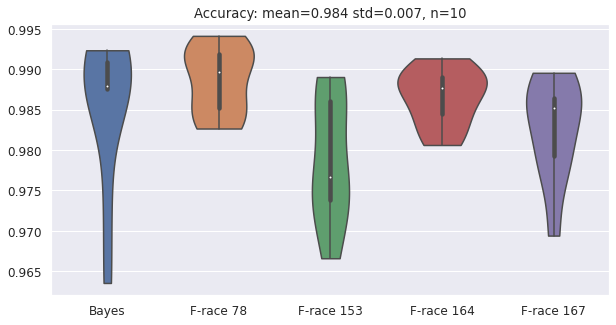

In [197]:
summarize_performance(overall_accs.iloc[:,:5])

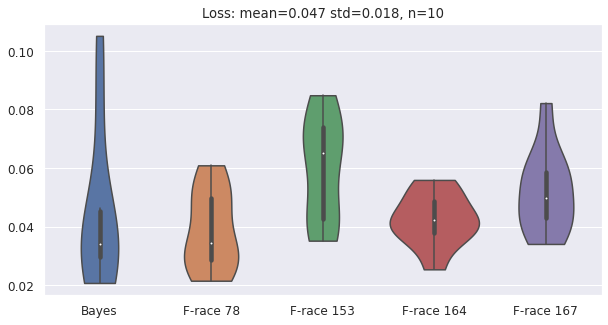

In [198]:
summarize_performance(overall_losses.iloc[:,:5], measure="Loss")

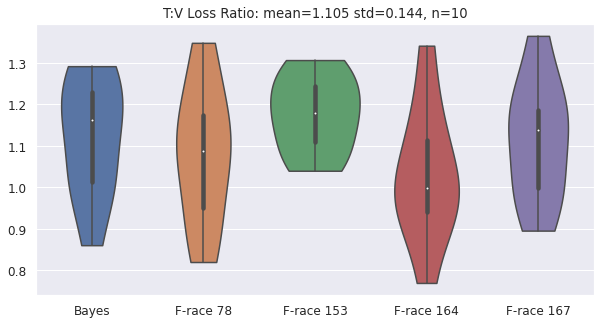

In [199]:
summarize_performance(overall_ratios.iloc[:,:5], measure="T:V Loss Ratio")

In [192]:
overall_losses.mean(axis=0)

Bayes         0.044544
F-race 78     0.038802
F-race 153    0.059723
F-race 164    0.042427
F-race 167    0.051958
F-race 171    0.114332
dtype: float64

## Code-cleaned Version F-Race